## a)
Daten aus der Zipdatei lesen

In [22]:
import zipfile
import json
from pathlib import Path

path = Path('foods-2011-10-03.json.zip')

with zipfile.ZipFile(path, "r") as z:
    print("Inhalt des ZIP:", z.namelist())
    json_filename = None
    for name in z.namelist():
        if name.lower().endswith(".json"):
            json_filename = name
            break
    assert json_filename is not None, "Keine JSON-Datei im ZIP gefunden."

    with z.open(json_filename) as f:
        data = json.load(f)

print("Anzahl Einträge (Foods):", len(data))

Inhalt des ZIP: ['foods-2011-10-03.json']
Anzahl Einträge (Foods): 6636


b) Die Datenbank steht nun in Form einer Liste aus 6636 Python-Dictionaries zu Verfügung. Jedes Dictionary enthält Angaben zu einem Nahrungsmittel. Greifen Sie sich ein beliebiges Nahrungsmittel heraus und lassen sich die Namen der Einträge mit der Methode `dict.keys()` anzeigen. Einer der Einträge enthält die enthaltenen Nährstoffe (`nutrients`), ebenfalls als Dictionary. Lassen Sie sich wiederum einen beliebigen Eintrag der Nährstoffliste anzeigen. Es sollte auffallen, dass manche Feldnamen doppelt vorkommen.

Teile dieser hierarchischen Struktur sollen nun in eine einheitliche Tabelle umgewandelt werden, um eine explorative Analyse durchführen zu können.

Vorgehensweise:

* Kopieren Sie zunächst die Felder `description`,`group`,`id`,`manufacturer` in einen eigenen DataFrame `info`, sowie alle Nährstofflisten in ein Array von DataFrames, wobei Sie an jeden DataFrame die entsprechende ID des Nahrungsmittels als eigene Spalte anhängen.
* Dieses Array wird mithilfe der Funktion `pandas.concat()` zu einem großen DataFrame nutrients (389355 Einträge) vereinigt.
* Entfernen Sie alle Duplikate aus diesem DataFrame.
* Bevor beide DataFrames vereinigt werden können, gibt es noch ein Problem: beide enthalten Felder mit dem Namen `description` und `group` (s.o.). Benennen Sie diese daher mithilfe von DataFrame.rename() in eindeutige Namen um.
* Vereinigen Sie beide DataFrames mit `pandas.merge(nutrients, info, on=’id’, how=’outer’)` anhand der Nahrungsmittel-ID.

Überprüfen Sie das Ergebnis jeder Manipulation mit `DataFrame.head()``.

In [23]:
import pandas as pd

info = pd.DataFrame([
    {
        'id': item.get('id'),
        'description': item.get('description'),
        'group': item.get('group'),
        'manufacturer': item.get('manufacturer')
    }
    for item in data
])
info.head()

,id,description,group,manufacturer
0,1008,"Cheese, caraway",Dairy and Egg Products,
1,1009,"Cheese, cheddar",Dairy and Egg Products,
2,1018,"Cheese, edam",Dairy and Egg Products,
3,1019,"Cheese, feta",Dairy and Egg Products,
4,1028,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,


In [24]:
nutrient_dfs = []
for item in data:
    nutrients_list = item.get('nutrients', [])
    if nutrients_list:
        df_n = pd.DataFrame(nutrients_list)
        df_n['id'] = item.get('id')
        nutrient_dfs.append(df_n)

nutrients = pd.concat(nutrient_dfs, ignore_index=True)
nutrients.head()

,value,units,description,group,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


In [25]:
print("nutrients (vor drop_duplicates) shape:", nutrients.shape)
nutrients = nutrients.drop_duplicates().reset_index(drop=True)
print("nutrients (nach drop_duplicates) shape:", nutrients.shape)
nutrients.head()

nutrients (vor drop_duplicates) shape: (389355, 5)
nutrients (nach drop_duplicates) shape: (375176, 5)


,value,units,description,group,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


In [26]:
nutrients = nutrients.rename(columns={'description': 'nutrient_description', 'group': 'nutrient_group'})
nutrients.head()


,value,units,nutrient_description,nutrient_group,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


In [27]:
info = info.rename(columns={'description': 'food_description', 'group': 'food_group'})
info.head()

,id,food_description,food_group,manufacturer
0,1008,"Cheese, caraway",Dairy and Egg Products,
1,1009,"Cheese, cheddar",Dairy and Egg Products,
2,1018,"Cheese, edam",Dairy and Egg Products,
3,1019,"Cheese, feta",Dairy and Egg Products,
4,1028,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,


In [28]:
merged = pd.merge(nutrients, info, on='id', how='outer')
merged.head()

,value,units,nutrient_description,nutrient_group,id,food_description,food_group,manufacturer
0,25.18,g,Protein,Composition,1008,"Cheese, caraway",Dairy and Egg Products,
1,29.20,g,Total lipid (fat),Composition,1008,"Cheese, caraway",Dairy and Egg Products,
2,3.06,g,"Carbohydrate, by difference",Composition,1008,"Cheese, caraway",Dairy and Egg Products,
3,3.28,g,Ash,Other,1008,"Cheese, caraway",Dairy and Egg Products,
4,376.00,kcal,Energy,Energy,1008,"Cheese, caraway",Dairy and Egg Products,


c) Nun sind die Daten bereit für die Untersuchung auf das Spurenelement Zink (Feldname: `Zinc, Zn`). Lesen Sie dazu alle Tabelleneinträge mithilfe einer geeigneten Indizierung in einen DataFrame aus, der nur Einträge zum Nährstoff Zink enthält. Daraus wählen Sie wiederum die Spalte mit dem Zinkgehalt in mg (`value`) aus und stellen dafür ein Histogramm und eine Liste deskriptiver Statistiken dar. Finden Sie in Ihrer Tabelle Edamer (`Cheese, edam`). Hat Edamer einen überdurchschnittlichen Zinkgehalt? Haben mehr als 75% aller Nahrungsmittel einen kleineren Zinkgehalt? Welches Nahrungsmittel hat den maximalen Zinkgehalt?

Deskriptive Statistik für Zink (mg):
count    6137.000000
mean        2.228589
std         3.975321
min         0.000000
25%         0.340000
50%         0.980000
75%         2.980000
max        90.950000
Name: zinc_mg, dtype: float64


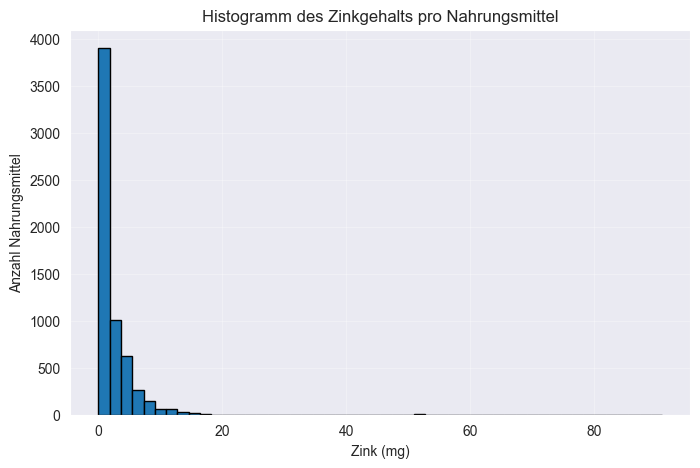


Edamer gefunden (Einträge):
     id food_description  zinc_mg
2  1018     Cheese, edam     3.75

Edamer: mittlerer Zinkwert = 3.750 mg

Durchschnittlicher Zinkgehalt aller Nahrungsmittel: 2.229 mg
Hat Edamer einen überdurchschnittlichen Zinkgehalt?: True
Anteil der Nahrungsmittel mit kleinerem Zinkgehalt als Edamer: 80.626%
Haben mehr als 75% einen kleineren Zinkgehalt?: True

Nahrungsmittel mit maximalem Zinkgehalt:
{'id': 15170, 'zinc_mg': 90.95, 'food_description': 'Mollusks, oyster, eastern, canned'}


In [29]:
import matplotlib.pyplot as plt
import numpy as np

nutrient_col = 'nutrient_description'
food_col = 'food_description'
value_col = 'value'

zinc_df = merged[merged[nutrient_col] == 'Zinc, Zn'].copy()

# Aggregiere pro Nahrungsmittel (ein Wert pro id), nehme das Maximum falls mehrfach vorhanden
per_food = zinc_df.groupby('id').agg(
    {value_col: 'max', food_col: 'first'}
).rename(columns={value_col: 'zinc_mg', food_col: 'food_description'}).reset_index()

stats = per_food['zinc_mg'].describe()
print("Deskriptive Statistik für Zink (mg):")
print(stats)

# Histogramm
plt.figure(figsize=(8, 5))
plt.hist(per_food['zinc_mg'].dropna(), bins=50, color='C0', edgecolor='black')
plt.xlabel('Zink (mg)')
plt.ylabel('Anzahl Nahrungsmittel')
plt.title('Histogramm des Zinkgehalts pro Nahrungsmittel')
plt.grid(alpha=0.3)
plt.show()

edam_rows = per_food[per_food['food_description'].str.contains('Cheese, edam', case=False, na=False)]
if not edam_rows.empty:
    # Falls mehrere Varianten, nehme den Mittelwert bzw. liste alle
    edam_vals = edam_rows['zinc_mg'].values
    edam_mean = edam_vals.mean()
    print("\nEdamer gefunden (Einträge):")
    print(edam_rows[['id', 'food_description', 'zinc_mg']])
    print(f"\nEdamer: mittlerer Zinkwert = {edam_mean:.3f} mg")
else:
    edam_mean = np.nan
    print("\nEdamer ('Cheese, edam') nicht in der Zink-Tabelle gefunden.")

# Überdurchschnittlich?
mean_zinc = per_food['zinc_mg'].mean()
if not np.isnan(edam_mean):
    print(f"\nDurchschnittlicher Zinkgehalt aller Nahrungsmittel: {mean_zinc:.3f} mg")
    print("Hat Edamer einen überdurchschnittlichen Zinkgehalt?:", edam_mean > mean_zinc)

# Anteil der Nahrungsmittel mit kleinerem Zinkgehalt als Edamer
if not np.isnan(edam_mean):
    prop_smaller = (per_food['zinc_mg'] < edam_mean).mean()
    print(f"Anteil der Nahrungsmittel mit kleinerem Zinkgehalt als Edamer: {prop_smaller:.3%}")
    print("Haben mehr als 75% einen kleineren Zinkgehalt?:", prop_smaller > 0.75)

# Nahrungsmittel mit maximalem Zinkgehalt
idx_max = per_food['zinc_mg'].idxmax()
max_row = per_food.loc[idx_max]
print("\nNahrungsmittel mit maximalem Zinkgehalt:")
print(max_row.to_dict())


In [30]:
%load_ext version_information
%version_information numpy, pandas

Software versions
Python 3.10.7 64bit [MSC v.1933 64 bit (AMD64)]
IPython 8.13.2
OS Windows 10 10.0.26200 SP0
numpy 1.23.3
pandas 2.0.1
Tue Oct 28 10:07:43 2025 Mitteleuropäische Zeit